# ODIN method

This notebook aims at evaluating the **ODIN method**.

Here, we focus on a ResNet18 network trained on CIFAR-10. This model is challenged on
LSUN OOD dataset.

**Reference**  
_Enhancing The Reliability of Out-of-distribution Image Detection in Neural Networks_  
Liang, Shiyu and Li, Yixuan and Srikant, R.  
International Conference on Learning Representations, 2018  
<https://openreview.net/forum?id=H1VGkIxRZ>


## Load CIFAR-10 dataset and pretrained ResNet18 model

The CIFAR-10 dataset is loaded and preprocessed (normalized to 0-1). This is our
in-distribution dataset.

A pretrained ResNet18 model is loaded and evaluated on CIFAR-10 test set.


In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 

import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, PILToTensor, Resize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from oodeel.datasets import OODDataset
from oodeel.eval.metrics import bench_metrics
from oodeel.methods import ODIN
from oodeel.models.training_funs import train_torch_model

Note that models are saved at *~/.oodeel/saved_models* and data is supposed to be found at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

Load CIFAR-10, our in-distribution from `tensorflow_datasets`. 

/!\ We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data with `_out` to avoid confusion with OOD detection which is the name of the task, and is therefore used to denote core classes such as `OODDataset` and `OODModel`.

In [3]:
oods_in = OODDataset('CIFAR10', backend="torch", load_kwargs={"root": data_path, "train": False, "download": True})
oods_train = OODDataset('CIFAR10', backend="torch", load_kwargs={"root": data_path, "train": False, "download": True})

def preprocess_fn(inputs):
    x = inputs[0] / 255.0
    x = transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )(x)
    return tuple([x] + list(inputs[1:]))

batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Train or load a model on in-distribution data (CIFAR-10). Note that `.get_dataset()` is used to return the unprepared `tf.data.Dataset`, that is automatically prepared, preprocessed and augmented by `train_keras_app`. To prepare the dataset with your own pipeline, set `is_prepared=True` in `train_config` dict.

In [4]:
model_path_cifar = os.path.join(model_path, "cifar10")
try:
    # model = torch.load(os.path.join(model_path_cifar, "best.pt"))
    model = torch.load(os.path.join(model_path_cifar, "dknn_cifar10.pt"))  # pretrained resnet18

except OSError:
    train_config = {
        "num_classes": 10,
        "model_name": "resnet18",
        "epochs": 200,
        "save_dir": model_path_cifar,
        "validation_data": ds_in  # ds_in is actually the test set of CIFAR10
    }

    model = train_torch_model(ds_train, **train_config)

model.eval()
model = model.to(device)

## Load LSUN cropped dataset

Second, the LSUN cropped dataset is loaded and preprocessed. This is our
out-of-distribution dataset.

**Note**: see https://github.com/facebookresearch/odin to download OOD datasets from the
original paper. Some OOD datasets have images of size 36x36 pixels: a black frame of 2 pixels surrounds the
32x32 image. In this case, the image is cropped to 32x32 pixels.


In [5]:
image_folder_transform = Compose([PILToTensor(), Resize((32, 32))])

# LSUN
lsun_kwargs = {"root": os.path.join(data_path, "LSUN_tvs"), "transform": image_folder_transform}

# ood dataset
ds_out = OODDataset(ImageFolder(**lsun_kwargs), backend="torch").prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

## OOD detection

Here the ODIN method is applied on both ID and OOD images. The OOD score is computed for
each image and some metrics are measured to evaluate the performance of the OOD
detector.

In a nutshell, the ODIN method consists of the three following steps:

1. Perturb the input image by applying a gradient descent step in order to increase the
   calibrated probability score of the predicted class.
2. Compute the calibrated probability score of the perturbed image. This is defined as
   the OOD score.
3. If the OOD score is below a threshold, the image is considered as OOD.

The _calibrated probability_ is the temperature-scaled softmax of the logits where the
temperature is a hyper-parameter of the method. The step in the gradient descent
perturbation of the image is also a hyper-parameter.

First, fit ODIN to the model at hand, and score data.


In [6]:
oodmodel = ODIN(temperature=1000)
oodmodel.fit(model)

scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

/home/yannick.prudent/1_OODEEL/oodeel/oodeel/utils/torch_operator.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(tensor)


Compute the evaluation metrics based on the scores of the test data, and visualize the scores histogram.

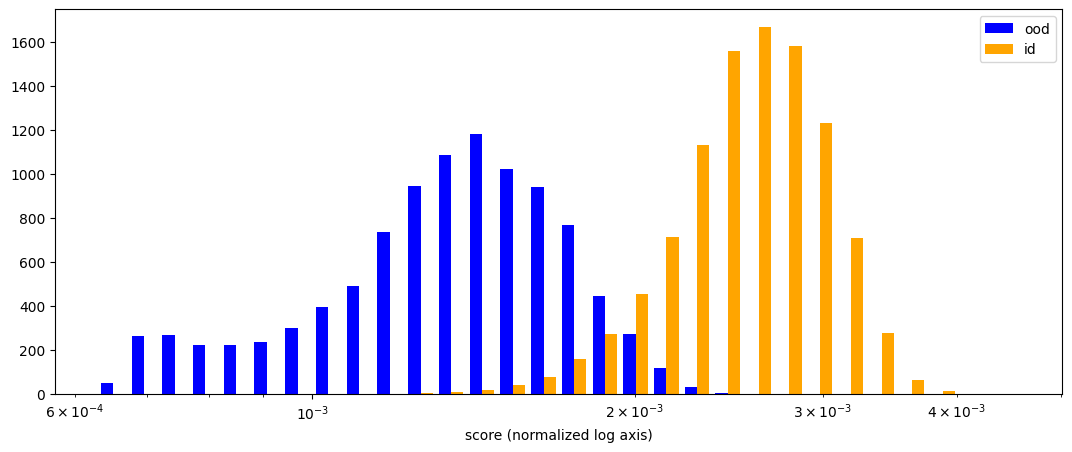

auroc       0.990127
fpr95tpr    0.051700
dtype: float64


In [7]:
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)

def plot_hist(scores_in, scores_out, bins, log=False, invert_order=False):
    if log:
        if invert_order:
            scores_in = - scores_in
            scores_out = - scores_out
        minim = np.min([np.min(scores_in), np.min(scores_out)])
        scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        _, bins = np.histogram(np.concatenate([scores_in_, scores_out_]), bins=30)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.xscale('log')
        plt.xlabel("score (normalized log axis)")
    else:
        logbins=bins
        scores_in_ = scores_in 
        scores_out_ = scores_out
        plt.xlabel("score")
    plt.hist((scores_out_, scores_in_), bins=logbins, color=("blue", "orange"), label=("ood", "id"))
    plt.legend()
    plt.show()

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30, log=True, invert_order=True)
metrics = pd.Series(metrics)
print(metrics)

## BONUS

Bonus experiment: 
* Compare calibrated softmax outputs from original and perturbed images for a single batch.
* Compare the shift between outputs of original and pertubated images for in-distribution and out-of-distribution data. 
* Compute the number of output label shift after image perturbation for in-distribution and out-of-distribution data.

In [8]:
# for img in ds_out.take(1):
#     img_out = img[0]

# for img in ds_in.take(1):
#     img_in = img[0]

# img_perturbed_out = oodmodel.input_perturbation(img_out)
# img_perturbed_in = oodmodel.input_perturbation(img_in)
# perturbations_out = img_perturbed_out - img_out
# perturbations_in = img_perturbed_in - img_in

# def get_max_argmax(img):
#     preds = tf.nn.softmax(model.predict(img) / oodmodel.temperature).numpy()
#     maxx = preds.max(axis=-1)
#     argmaxx = preds.argmax(axis=-1).squeeze()
#     return maxx, argmaxx
# # Outputs for original images

# max_out, argmax_out = get_max_argmax(img_out)
# max_in, argmax_in = get_max_argmax(img_in)
# max_per_out, argmax_per_out = get_max_argmax(img_perturbed_out)
# max_per_in, argmax_per_in = get_max_argmax(img_perturbed_in)

In [9]:
# plt.figure(figsize=(13, 10))
# plt.subplot(221)
# plt.plot(max_out, "*--")
# plt.plot(max_per_out, "*--")
# plt.title("Max of calibrated OOD softmax outputs")
# plt.legend(["Original", "Perturbed"])
# plt.subplot(222)
# plt.plot(max_in, "*--")
# plt.plot(max_per_in, "*--")
# plt.title("Max of calibrated ID softmax outputs")
# plt.legend(["Original", "Perturbed"])
# plt.show()

# plt.figure(figsize=(13, 5))
# plt.hist((max_per_out, max_per_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
# plt.title("max perturbated softmax for OOD and ID data")
# plt.legend()
# plt.show()

# plt.figure(figsize=(13, 5))
# plt.hist((max_per_out - max_out, max_per_in - max_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
# plt.title("difference between max perturbated softmax and max softmax for OOD and ID data")
# plt.legend()
# plt.show()


# nb_label_shifts_out = np.where(argmax_out != argmax_per_out)[0].shape[0]
# nb_label_shifts_in = np.where(argmax_in != argmax_per_in)[0].shape[0]
# print("Number of label shift for OOD data: ", nb_label_shifts_out)
# print("Number of label shift for ID data: ", nb_label_shifts_in)
